In [113]:
import pandas as pd 
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.dates as mdates
import matplotlib as mpl

import itertools
#from pmdarima import auto_arima

#statsmodels

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

%matplotlib inline

In [114]:
# average(median) price across time with Texas Zipcode (most expensive, least expensive)
# pull out top 10 least expensive zipcode 
# train 15 years of data 
# rmse/mse 
# baseline -> shift 
# from sklearn.model_selection import TimeSeriesSplit

In [115]:
df = pd.read_csv("time-series/zillow_data.csv")

In [116]:
df_texas = df[(df['State'] == 'TX')]
df_texas = df_texas.drop('RegionID', axis = 1)
df_texas

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,95700.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
8,77449,Katy,TX,Houston,Harris,9,95400.0,95600.0,95800.0,96100.0,...,166800,167400,168400,169600,170900,172300,173300,174200,175400,176200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14372,76941,Mertzon,TX,San Angelo,Irion,14373,NaN,NaN,NaN,NaN,...,122500,121800,121600,122200,123500,124700,124300,122600,121600,121600
14472,79313,Anton,TX,Levelland,Hockley,14473,NaN,NaN,NaN,NaN,...,55400,56300,55700,56300,58900,61500,63000,63600,63500,63300
14492,79355,Plains,TX,NaN,Yoakum,14493,NaN,NaN,NaN,NaN,...,100500,100500,101000,100700,99700,97700,95800,94600,94000,93500
14599,79366,Ransom Canyon,TX,Lubbock,Lubbock,14600,134500.0,134500.0,134400.0,134400.0,...,252100,251600,251600,251500,251300,251500,251700,252500,255000,257500


In [117]:
total_plot = df.describe().drop(['RegionName', 'SizeRank', 'RegionID'], axis = 1)
index = total_plot.index
index.name = "Date"
total_plot = total_plot.T
total_plot
texas_plot = df_texas.describe().drop(['RegionName', 'SizeRank'], axis = 1)
index = texas_plot.index
index.name = "Date"
texas_plot = texas_plot.T
#texas_plot
total_plot

Date,count,mean,std,min,25%,50%,75%,max
1996-04,13684.0,118299.123063,86002.509608,11300.0,68800.0,99500.0,143200.0,3676700.0
1996-05,13684.0,118419.044139,86155.673905,11500.0,68900.0,99500.0,143300.0,3704200.0
1996-06,13684.0,118537.423268,86309.226295,11600.0,69100.0,99700.0,143225.0,3729600.0
1996-07,13684.0,118653.069278,86467.945969,11800.0,69200.0,99700.0,143225.0,3754600.0
1996-08,13684.0,118780.254312,86650.941365,11800.0,69375.0,99800.0,143500.0,3781800.0
...,...,...,...,...,...,...,...,...
2017-12,14723.0,281095.320247,367045.388033,14300.0,129900.0,193400.0,313400.0,18307100.0
2018-01,14723.0,282657.060382,369572.741938,14100.0,130600.0,194100.0,315100.0,18365900.0
2018-02,14723.0,284368.688447,371773.905107,13900.0,131050.0,195000.0,316850.0,18530400.0
2018-03,14723.0,286511.376757,372461.234695,13800.0,131950.0,196700.0,318850.0,18337700.0


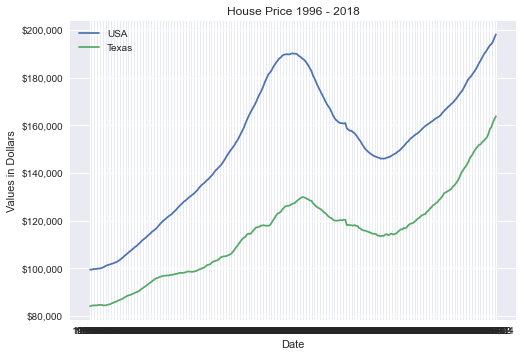

In [118]:
plt.style.use('seaborn')
date = pd.date_range(start='1996-04', end = '2018-04', freq='M').strftime('%Y-%m')
date = date.to_series()

# setting figure size to 12, 10
fig, ax = plt.subplots()
 
# Labelling the axes and setting

ax.set_xlabel("Date")
ax.set_ylabel("Values in Dollars")
ax.set_title("House Price 1996 - 2018")



ax.plot(total_plot['50%'])
ax.plot(texas_plot["50%"])
ax.legend(['USA', 'Texas'])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.labelbottom'] = True
#ticks = ax.get_xticks()
#ax.xticks([tick for tick in ticks if tick%24 == 0])
#ax.xaxis.set_major_locator(mdates.YearLocator(interval=1))   #to get a tick every 15 minutes
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y:%m'))     #optional formatting 


# 15,000 house price from 1996 - 2018 were collected from zillow 
# green represents the median house price of the USA and blue represents the median house price of Texas 
# The peak in the middle was October 2007 right before Subprime Mortgage crisis 
# For the stability of the house, we looked over the price changes during the price drop 

In [119]:
texas_stability = df_texas.copy()
date = pd.date_range(start='1996-04', end = '2007-10', freq='M').strftime('%Y-%m')
date = date.to_series()
date2 = pd.date_range(start='2007-12', end = '2011-11', freq='M').strftime('%Y-%m')
date2 = date2.to_series()
date3 = pd.date_range(start='2012-01', end = '2018-05', freq='M').strftime('%Y-%m')
date3 = date3.to_series()
texas_stability = texas_stability.drop(date, axis = 1)
texas_stability = texas_stability.drop(date2, axis = 1)
texas_stability = texas_stability.drop(date3, axis = 1)
texas_stability = texas_stability.drop(['SizeRank'], axis = 1)
texas_stability_plot = texas_stability.copy()
texas_stability_plot
texas_stability_plot['stability1'] = (texas_stability_plot['2011-11'] - texas_stability_plot['2007-10'])/texas_stability_plot['2007-10']
texas_stability_plot['stability2'] = (texas_stability_plot['2011-12'] - texas_stability_plot['2007-10'])/texas_stability_plot['2007-10']
texas_stability_plot['stability3'] = (texas_stability_plot['2011-11'] - texas_stability_plot['2007-11'])/texas_stability_plot['2007-11']
texas_stability_plot['stability4'] = (texas_stability_plot['2011-12'] - texas_stability_plot['2007-11'])/texas_stability_plot['2007-11']
texas_stability_plot['mean'] = (texas_stability_plot['stability1']+texas_stability_plot['stability2']+texas_stability_plot['stability3']+texas_stability_plot['stability4'])/4*100
texas_stability_plot = texas_stability_plot.dropna()
texas_stability_plot = texas_stability_plot[texas_stability_plot.RegionName < 75400]
texas_stability_plot.sort_values('stability1', ascending = False).head(20)

,RegionName,City,State,Metro,CountyName,2007-10,2007-11,2011-11,2011-12,stability1,stability2,stability3,stability4,mean
2813,75238,Dallas,TX,Dallas-Fort Worth,Dallas,225800.0,226400.0,233800.0,233200.0,0.035430,0.032772,0.032686,0.030035,3.273070
1756,75028,Flower Mound,TX,Dallas-Fort Worth,Denton,218500.0,218900.0,225400.0,226000.0,0.031579,0.034325,0.029694,0.032435,3.200818
995,75023,Plano,TX,Dallas-Fort Worth,Collin,170200.0,170400.0,172500.0,172400.0,0.013514,0.012926,0.012324,0.011737,1.262513
757,75025,Plano,TX,Dallas-Fort Worth,Collin,232900.0,232900.0,235200.0,235100.0,0.009875,0.009446,0.009875,0.009446,0.966080
820,75080,Richardson,TX,Dallas-Fort Worth,Dallas,172200.0,172700.0,172600.0,172700.0,0.002323,0.002904,-0.000579,0.000000,0.116186
277,75035,Frisco,TX,Dallas-Fort Worth,Collin,238100.0,238000.0,238300.0,237800.0,0.000840,-0.001260,0.001261,-0.000840,0.000004
6201,75094,Murphy,TX,Dallas-Fort Worth,Collin,258800.0,259800.0,255200.0,254800.0,-0.013910,-0.015456,-0.017706,-0.019246,-1.657945
54,75287,Dallas,TX,Dallas-Fort Worth,Dallas,229800.0,228600.0,224800.0,226300.0,-0.021758,-0.015231,-0.016623,-0.010061,-1.591821
10798,75182,Sunnyvale,TX,Dallas-Fort Worth,Dallas,294900.0,293600.0,287700.0,288600.0,-0.024415,-0.021363,-0.020095,-0.017030,-2.072589
2535,75077,Lewisville,TX,Dallas-Fort Worth,Denton,201100.0,201900.0,195600.0,196200.0,-0.027350,-0.024366,-0.031204,-0.028232,-2.778773


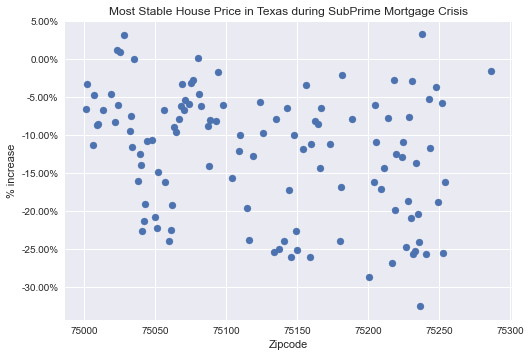

In [120]:
plt.style.use('seaborn')
fig, ax = plt.subplots()
ax.scatter('RegionName', 'mean', data = texas_stability_plot)
ax.set_title('Most Stable House Price in Texas during SubPrime Mortgage Crisis')
ax.set_xlabel('Zipcode')
ax.set_ylabel('% increase')
ax.yaxis.set_major_formatter('{x:0.2f}%')

# About 98% house price in Texas lost more than 5% of their value up to 48% of house price decreased. 
# Interestingly we noticed that some house price actually increased even during the Mortgage Crisis
# 

In [121]:
texas_stability_plot.sort_values('stability1', ascending = False).head(20)

,RegionName,City,State,Metro,CountyName,2007-10,2007-11,2011-11,2011-12,stability1,stability2,stability3,stability4,mean
2813,75238,Dallas,TX,Dallas-Fort Worth,Dallas,225800.0,226400.0,233800.0,233200.0,0.035430,0.032772,0.032686,0.030035,3.273070
1756,75028,Flower Mound,TX,Dallas-Fort Worth,Denton,218500.0,218900.0,225400.0,226000.0,0.031579,0.034325,0.029694,0.032435,3.200818
995,75023,Plano,TX,Dallas-Fort Worth,Collin,170200.0,170400.0,172500.0,172400.0,0.013514,0.012926,0.012324,0.011737,1.262513
757,75025,Plano,TX,Dallas-Fort Worth,Collin,232900.0,232900.0,235200.0,235100.0,0.009875,0.009446,0.009875,0.009446,0.966080
820,75080,Richardson,TX,Dallas-Fort Worth,Dallas,172200.0,172700.0,172600.0,172700.0,0.002323,0.002904,-0.000579,0.000000,0.116186
277,75035,Frisco,TX,Dallas-Fort Worth,Collin,238100.0,238000.0,238300.0,237800.0,0.000840,-0.001260,0.001261,-0.000840,0.000004
6201,75094,Murphy,TX,Dallas-Fort Worth,Collin,258800.0,259800.0,255200.0,254800.0,-0.013910,-0.015456,-0.017706,-0.019246,-1.657945
54,75287,Dallas,TX,Dallas-Fort Worth,Dallas,229800.0,228600.0,224800.0,226300.0,-0.021758,-0.015231,-0.016623,-0.010061,-1.591821
10798,75182,Sunnyvale,TX,Dallas-Fort Worth,Dallas,294900.0,293600.0,287700.0,288600.0,-0.024415,-0.021363,-0.020095,-0.017030,-2.072589
2535,75077,Lewisville,TX,Dallas-Fort Worth,Denton,201100.0,201900.0,195600.0,196200.0,-0.027350,-0.024366,-0.031204,-0.028232,-2.778773


In [122]:
texas_stability_plot.sort_values('stability1', ascending = True).head(20)

,RegionName,City,State,Metro,CountyName,2007-10,2007-11,2011-11,2011-12,stability1,stability2,stability3,stability4,mean
5670,75237,Dallas,TX,Dallas-Fort Worth,Dallas,136400.0,136100.0,91800.0,92000.0,-0.326979,-0.325513,-0.325496,-0.324026,-32.550377
4666,75201,Dallas,TX,Dallas-Fort Worth,Dallas,419000.0,420900.0,299100.0,300200.0,-0.286158,-0.283532,-0.289380,-0.286766,-28.645902
225,75217,Dallas,TX,Dallas-Fort Worth,Dallas,83100.0,82500.0,60600.0,60600.0,-0.270758,-0.270758,-0.265455,-0.265455,-26.810633
6411,75253,Dallas,TX,Dallas-Fort Worth,Dallas,108700.0,108300.0,80300.0,81200.0,-0.261270,-0.252990,-0.258541,-0.250231,-25.575784
5401,75146,Lancaster,TX,Dallas-Fort Worth,Dallas,132200.0,131900.0,97800.0,97300.0,-0.260212,-0.263994,-0.258529,-0.262320,-26.126372
6734,75159,Seagoville,TX,Dallas-Fort Worth,Dallas,116600.0,116900.0,86400.0,86200.0,-0.259005,-0.260720,-0.260907,-0.262618,-26.081248
4237,75232,Dallas,TX,Dallas-Fort Worth,Dallas,105000.0,104800.0,77900.0,78100.0,-0.258095,-0.256190,-0.256679,-0.254771,-25.643402
6479,75134,Lancaster,TX,Dallas-Fort Worth,Dallas,118500.0,118300.0,88100.0,88600.0,-0.256540,-0.252321,-0.255283,-0.251057,-25.380014
3923,75241,Dallas,TX,Dallas-Fort Worth,Dallas,81200.0,81100.0,60400.0,60200.0,-0.256158,-0.258621,-0.255240,-0.257707,-25.693133
6255,75137,Duncanville,TX,Dallas-Fort Worth,Dallas,128100.0,128000.0,95400.0,96500.0,-0.255269,-0.246682,-0.254688,-0.246094,-25.068321


In [123]:
texas_check = texas_stability.describe().T
texas_check
check = texas_check['50%'].between(100000, 114000)
sum(check)
#texas_check.index[texas_check.index==True].tolist()

2

In [124]:
date = pd.date_range(start='1996-04', end = '2018-04', freq='M').strftime('%Y-%m')

In [125]:
df2 = pd.read_csv("time-series/zillow_forecast.csv")

In [126]:
date = pd.date_range(start='2014-01', end = '2022-05', freq='M').strftime('%Y-%m')
#time_series = pd.Series(ex[date], index=date)

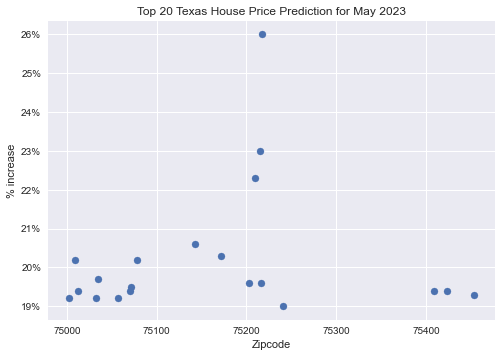

In [127]:
plt.style.use('seaborn')
f_predicted = df2.copy()
f_predicted = f_predicted[(df2['State'] == 'TX') & (df2['RegionName'] < 76400)]
#f_fixed['profit'] = (f_fixed['2023-05-31'] - f_fixed['2022-06-30'])/f_fixed['2022-06-30']
f_predicted['growth'] = f_predicted['2023-05-31'] - f_predicted['2022-06-30']
f_predicted = f_predicted.sort_values('growth', ascending=False)
f_predicted = f_predicted.iloc[:20]
f_predicted

fig, ax = plt.subplots()
ax.scatter('RegionName', 'growth', data = f_predicted)
ax.set_title('Top 20 Texas House Price Prediction for May 2023')
ax.set_xlabel('Zipcode')
ax.set_ylabel('% increase')
ax.yaxis.set_major_formatter('{x:1.0f}%')

In [128]:
texas_plot

Date,count,mean,std,min,25%,50%,75%,max
1996-04,944.0,109384.639831,86500.723167,24500.0,58600.0,84150.0,127475.0,772100.0
1996-05,944.0,109406.885593,86513.793243,24400.0,58600.0,84350.0,127475.0,765800.0
1996-06,944.0,109451.377119,86556.849806,24400.0,58675.0,84500.0,127500.0,760200.0
1996-07,944.0,109521.504237,86627.879676,24400.0,58700.0,84500.0,127400.0,755200.0
1996-08,944.0,109613.983051,86735.859278,24300.0,58700.0,84500.0,127475.0,751100.0
...,...,...,...,...,...,...,...,...
2017-12,989.0,193761.274014,130955.337006,38800.0,112700.0,158300.0,235500.0,1245900.0
2018-01,989.0,194417.492417,131242.806116,39100.0,113000.0,159200.0,237200.0,1250200.0
2018-02,989.0,195503.134479,131960.676882,39100.0,113900.0,161100.0,237700.0,1258300.0
2018-03,989.0,197023.356926,133076.779193,39200.0,115000.0,162600.0,239700.0,1265800.0


In [129]:
texas_prediction = texas_plot.copy()
texas_prediction['date'] = texas_prediction.index


#texas_prediction['Date'] = pd.to_datetime(texas_prediction.Date)
#texas_median = texas_prediction.reset_index(drop=True, inplace=True)
texas_median = texas_prediction.drop(['count', 'mean', 'std', 'min', '25%', '75%', 'max'], axis = 1)
texas_median = texas_median.reset_index(drop=True)
#texas_count = texas_median.resample('D').sum()
# daily_count = daily_count[daily_count < 90]

# ts_dr = pd.date_range(daily_count.index[0], daily_count.index[-1])
# ts_daily = np.empty(shape=len(ts_dr))
# ts_daily = pd.Series(ts_daily)
# ts_daily = ts_daily.reindex(ts_dr)
# ts_daily = ts_daily.fillna(daily_count)
# ts_daily = ts_daily.interpolate()

# ts_weekly = ts_daily.resample('W').mean()

#fig, ax = plt.subplots()
#ax.plot(texas_median)
#texas_median = texas_median.groupby(['50%', 'date'])

texas_median['median'] = texas_median['50%']
texas_median = texas_median.drop(['50%'], axis = 1)
texas_median = texas_median.rename_axis(None, axis=1)
texas_median.set_index('date', inplace = True)
texas_median

,median
date,
1996-04,84150.0
1996-05,84350.0
1996-06,84500.0
1996-07,84500.0
1996-08,84500.0
...,...
2017-12,158300.0
2018-01,159200.0
2018-02,161100.0


In [130]:
#texas_median = texas_median.reset_index(level=0)
train = texas_median[:'2016-11']

test = texas_median['2016-11':]

# fig, ax = plt.subplots(figsize=(12, 8))
# ax.plot(train, label='train')
# ax.plot(test, label='test')
# ax.set_title('Train-Test Split');
# plt.legend();
test

,median
date,
2016-11,146100.0
2016-12,147100.0
2017-01,148100.0
2017-02,149300.0
2017-03,150200.0
2017-04,151000.0
2017-05,151800.0
2017-06,152000.0
2017-07,152900.0


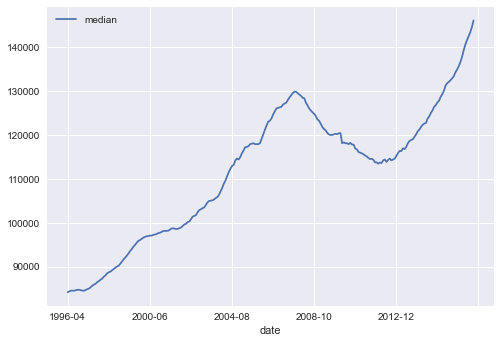

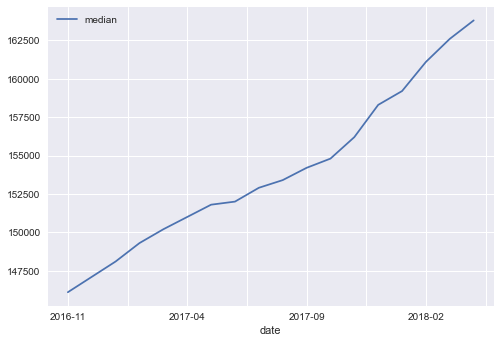

In [131]:
train.plot()
test.plot()
plt.show()

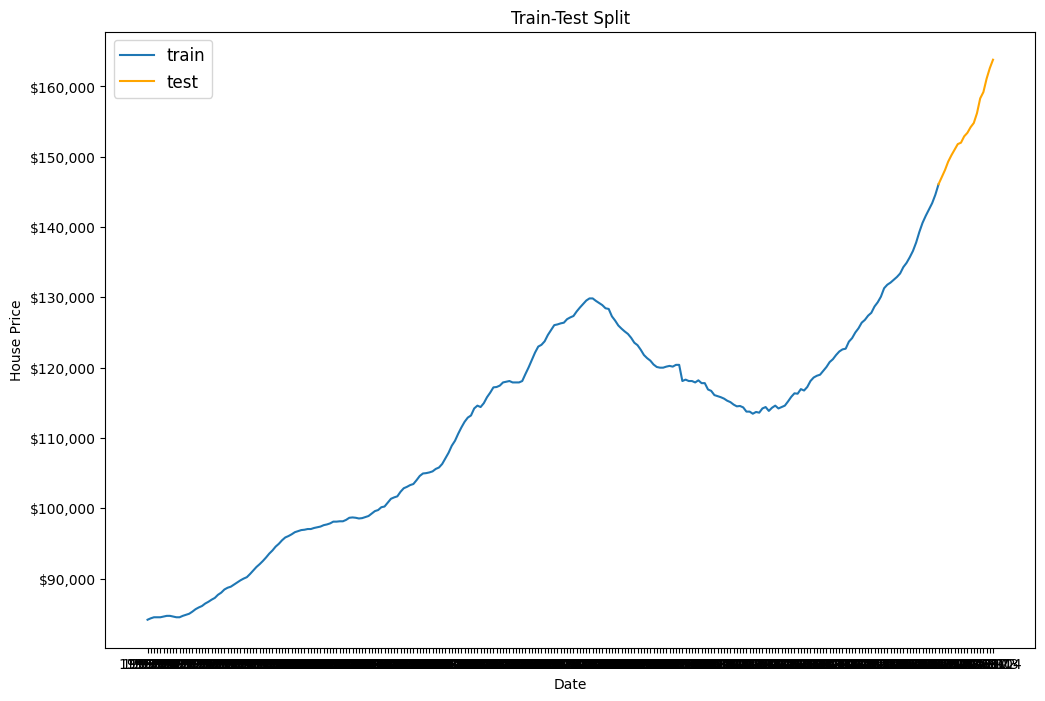

In [132]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label = 'train')
ax.plot(test, 'orange', label = 'test')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
ax.set_xlabel("Date")
ax.set_ylabel("House Price")

ax.set_title('Train-Test Split');
plt.legend();
leg = ax.legend(prop={"size":12})

In [133]:
model = ARIMA(train, order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-package

                               SARIMAX Results                                
Dep. Variable:                 median   No. Observations:                  248
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1831.142
Date:                Fri, 24 Jun 2022   AIC                           3672.283
Time:                        09:34:18   BIC                           3689.830
Sample:                    04-01-1996   HQIC                          3679.348
                         - 11-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0505      0.018     -2.807      0.005      -0.086      -0.015
ar.L2          0.9491      0.020     46.721      0.000       0.909       0.989
ma.L1          0.1352      0.040      3.386      0.0

C:\Users\wjsdn\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [134]:
predict = model_fit.predict()

predict = pd.DataFrame(predict)

predict['date'] = pd.to_datetime(predict.index.strftime('%Y-%m'))
predict["date"] = predict["date"].dt.strftime('%Y-%m')
predict = predict.set_index('date')
predict_plot = predict[1:]
predict_plot

,predicted_mean
date,
1996-05,85496.535364
1996-06,85508.256039
1996-07,85428.332955
1996-08,85318.069477
1996-09,85145.717161
...,...
2016-07,141142.536842
2016-08,142200.011307
2016-09,143049.586695


In [135]:
train

,median
date,
1996-04,84150.0
1996-05,84350.0
1996-06,84500.0
1996-07,84500.0
1996-08,84500.0
...,...
2016-07,141600.0
2016-08,142500.0
2016-09,143400.0


In [139]:
fore = model_fit.forecast(steps=50)
fore



fore = pd.DataFrame(fore)

fore['date'] = pd.to_datetime(fore.index.strftime('%Y-%m'))
fore["date"] = fore["date"].dt.strftime('%Y-%m')
fore
fore = fore.set_index('date')
fore



,predicted_mean
date,
2016-12,146768.161791
2017-01,147358.454266
2017-02,147962.819301
2017-03,148492.566185
2017-04,149039.437084
2017-05,149514.621524
2017-06,150009.678169
2017-07,150435.692141
2017-08,150884.053207


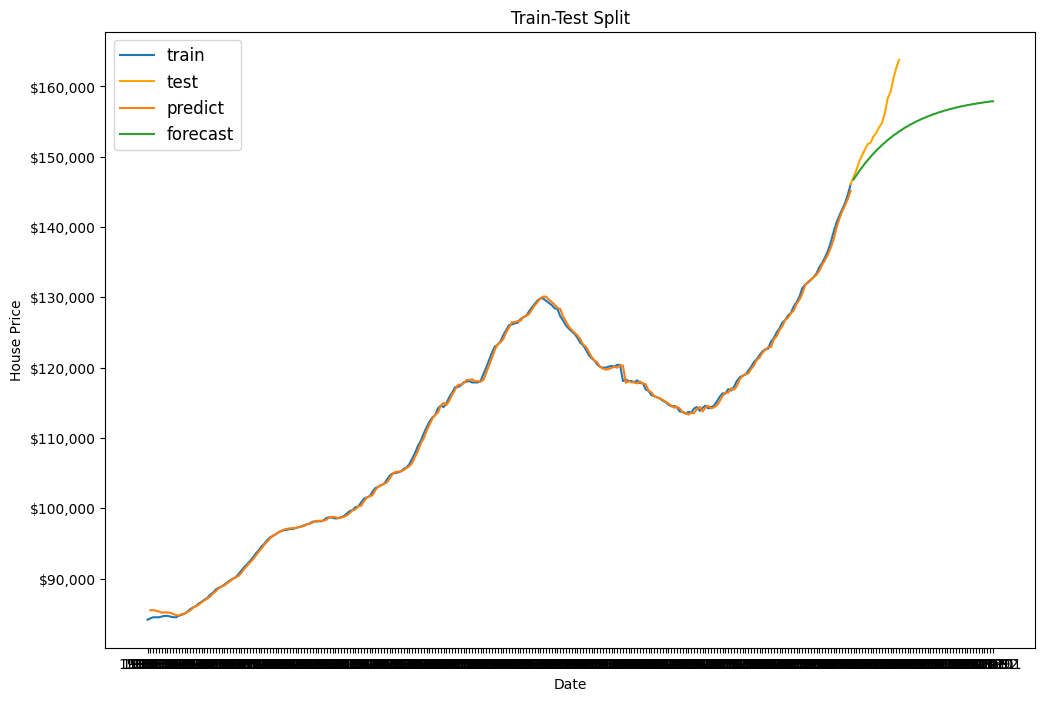

In [140]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label = 'train')
ax.plot(test, 'orange', label = 'test')
ax.plot(predict_plot, label = 'predict')
ax.plot(fore, label = 'forecast')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))
ax.set_xlabel("Date")
ax.set_ylabel("House Price")

ax.set_title('Train-Test Split');
plt.legend();
leg = ax.legend(prop={"size":12})

In [142]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
rmse = sqrt(mean_squared_error(predict['predicted_mean'][:18], test['median']))
rmse

75698.24458598274

In [144]:
test.mean()

75698/154000

0.49154545454545456

In [ ]:
fore = model_fit.forecast(steps=50)
fore



fore = pd.DataFrame(fore)

fore['date'] = pd.to_datetime(fore.index.strftime('%Y-%m'))
fore["date"] = fore["date"].dt.strftime('%Y-%m')
fore
fore = fore.set_index('date')
fore

